In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [4]:
from math import pow, sqrt

from enum import Enum
from typing import List, Tuple

class Pixel:
    def __init__(self, pos: List[float]):
        assert len(pos) == 2
        self.pos = tuple(pos) # type: Tuple[float, float]

    @property
    def x(self) -> float:
        return self.pos[0]

    @property
    def y(self) -> float:
        return self.pos[1]

    @property
    def pos_int(self) -> Tuple[int, int]:
        return (int(self.x), int(self.y))
    

class Vector:
    def __init__(self, p1: Pixel, p2: Pixel):
        self.pixels = (p1, p2) # type: Tuple[Pixel, Pixel]

    @property
    def pos(self) -> Pixel:
        return Pixel([self.pixels[1].x - self.pixels[0].x, self.pixels[1].y - self.pixels[0].y])

    @property
    def dir(self) -> float:
        return self.pos.y / self.pos.x
    
    @property
    def abs(self) -> float:
        return sqrt(pow(self.pos.x, 2) + pow(self.pos.y, 2))

In [65]:
class JointType(Enum):
    head           = 1
    neck           = 2
    left_shoulder  = 3
    right_shoulder = 4
    left_elbow     = 5
    right_elbow    = 6
    left_hand      = 7
    right_hand     = 8
    torso          = 9
    left_hip       = 10
    right_hip      = 11
    left_knee      = 12
    right_knee     = 13
    left_foot      = 14
    right_foot     = 15

    def is_next(self, other: "JointType") -> bool:
        for bone_type in BoneType:
            if (self in bone_type.value) and (other in bone_type.value):
                return True
        return False


class BoneType(Enum):
    neck           = {JointType.head, JointType.neck}
    torso          = {JointType.neck, JointType.torso}
    left_up_arm    = {JointType.left_shoulder, JointType.left_elbow}
    left_down_arm  = {JointType.left_elbow, JointType.left_hand}
    right_up_arm   = {JointType.right_shoulder, JointType.right_elbow}
    right_down_arm = {JointType.right_elbow, JointType.right_hand}
    left_torso     = {JointType.left_shoulder, JointType.left_hip}
    left_up_leg    = {JointType.left_hip, JointType.left_knee}
    left_down_leg  = {JointType.left_knee, JointType.left_foot}
    right_torso    = {JointType.right_shoulder, JointType.right_hip}
    right_up_leg   = {JointType.right_hip, JointType.right_knee}
    right_down_leg = {JointType.right_knee, JointType.right_foot}
    
    @classmethod
    def pairs(self):
        pairs = set() # type: Set[Set[BoneType, BoneType]]
        i = 0
        for t1 in BoneType:
            j = 0
            for t2 in BoneType:
                if i < j and len(t1.value | t2.value) == 3:
                    pairs.add((t1, t2))
                j += 1
            i += 1
        return pairs

In [66]:
class Joint(Pixel):
    def __init__(self, type: JointType, pos: List[float]):
        super().__init__(pos)
        self.type = JointType(type) # type: JointType

    def is_next(self, other: "Joint") -> bool:
        return self.type.is_next(other.type)


class Bone(Vector):
    def __init__(self, j1: Joint, j2: Joint):
        assert j1.is_next(j2)
        super().__init__(j1, j2)
        self.type = BoneType({j1.type, j2.type}) # type: BoneType

    @property
    def joints(self) -> Tuple[Joint, Joint]:
        return self.pixels

In [67]:
dir = "./images/bodyparts/"
stamp = 1478268857926037
img_file = dir + str(stamp) + ".png"
json_file = dir + str(stamp) + ".json"

In [68]:
img = cv2.imread(img_file)

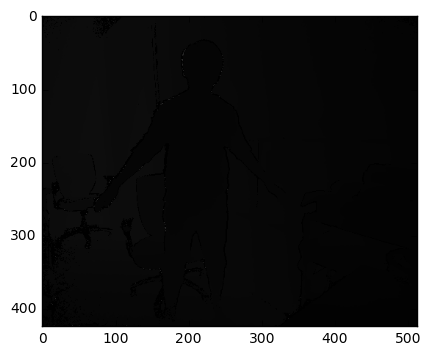

In [69]:
plt.imshow(img)

In [70]:
skeletons = pd.read_json(json_file)
skeleton = skeletons["skeletons"][0]

joints = [Joint(JointType(j["key"] + 1), j["value"]) for j in skeleton["joints"]] # type: List[Joint]

bones = [] # type: List[Bone]
for bone_type in BoneType:
    pair = [] # type: List[Joint]
    for jt in bone_type.value:
        list = [j for j in joints if j.type is jt]
        assert len(list) == 1
        pair.append(list[0])
    assert len(pair) == 2
    bones.append(Bone(pair[0], pair[1]))

pixels = [Pixel(p) for p in skeleton["pixels"]]

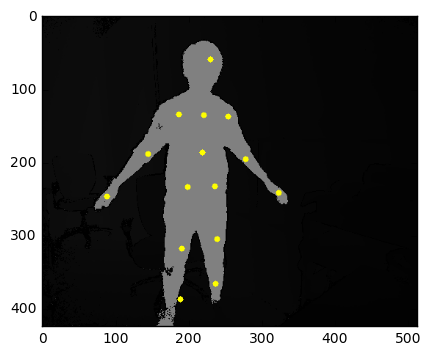

In [71]:
for px in pixels:
    img[px.y, px.x] = [128, 128, 128]
    
for j in joints:
    cv2.circle(img, j.pos_int, 4, (255, 255, 0), -1)
    
plt.imshow(img)

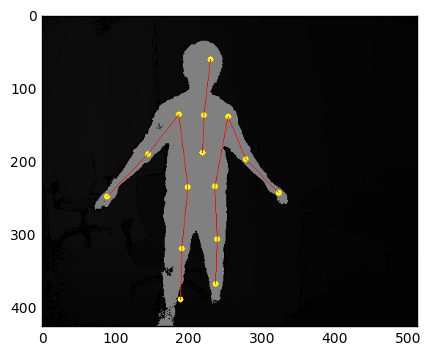

In [72]:
img_skeleton = img.copy()

for bone in bones:
    cv2.line(img_skeleton, bone.joints[0].pos_int, bone.joints[1].pos_int, (255, 0, 0))
        
plt.imshow(img_skeleton)

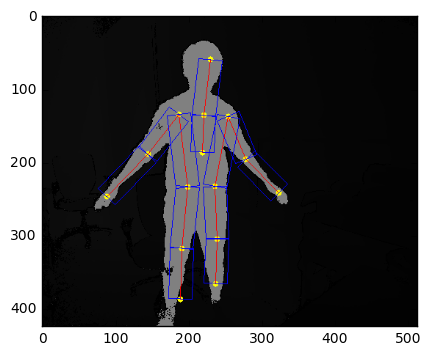

In [93]:
img_segmented = img_skeleton.copy()

for bone in bones:
    j0 = bone.joints[0]
    j1 = bone.joints[1]
    grad_inv = - pow(bone.dir, -1) # type: float

    a = 16
    b = a * pow(1 + pow(grad_inv, 2), -0.5)

    j00 = (int(j0.x - b), int(j0.y - grad_inv * b)) # type: Tuple[float, float]
    j01 = (int(j0.x + b), int(j0.y + grad_inv * b)) # type: Tuple[float, float]
    j10 = (int(j1.x - b), int(j1.y - grad_inv * b)) # type: Tuple[float, float]
    j11 = (int(j1.x + b), int(j1.y + grad_inv * b)) # type: Tuple[float, float]

    cv2.line(img_segmented, j00, j01, (0, 0, 255))
    cv2.line(img_segmented, j00, j10, (0, 0, 255))
    cv2.line(img_segmented, j01, j11, (0, 0, 255))
    cv2.line(img_segmented, j10, j11, (0, 0, 255))

        
plt.imshow(img_segmented)

['left_torso', 'left_up_leg']
left_hip (198.40699768066406, 234.2406768798828)
left_shoulder (186.48765563964844, 135.53271484375)
left_knee (190.07762145996094, 318.230224609375)
(182, 234)
(214, 234)
['left_up_leg', 'left_down_leg']
left_knee (190.07762145996094, 318.230224609375)
left_hip (198.40699768066406, 234.2406768798828)
left_foot (188.42604064941406, 387.01397705078125)
(174, 317)
(206, 319)
['right_up_arm', 'right_torso']
right_shoulder (253.7198486328125, 138.05406188964844)
right_elbow (277.9222412109375, 196.7187957763672)
right_hip (235.51084899902344, 233.79977416992188)
(252, 122)
(255, 153)
['neck', 'torso']
neck (220.67796325683594, 136.81491088867188)
head (229.29425048828125, 60.95027160644531)
torso (218.84539794921875, 187.0715789794922)
(204, 135)
(236, 138)
['right_torso', 'right_up_leg']
right_hip (235.51084899902344, 233.79977416992188)
right_shoulder (253.7198486328125, 138.05406188964844)
right_knee (238.99114990234375, 305.1847229003906)
(219, 232)
(251, 

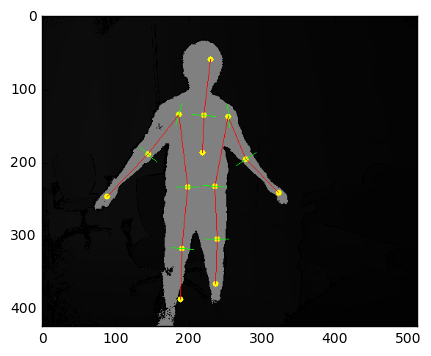

In [94]:
from math import sqrt, pow, atan2, tan

img_segmented2 = img_skeleton.copy()

grads = {} # type: Dict[Tuple[BoneType, BoneType], Vector]

for pair in BoneType.pairs():
    b1_list = [b for b in bones if b.type is pair[0]]
    assert len(b1_list) == 1
    b2_list = [b for b in bones if b.type is pair[1]]
    assert len(b2_list) == 1
    
    j1_list = set(b1_list[0].joints) # type: Set[Joint]
    j2_list = set(b2_list[0].joints) # type: Set[Joint]
    
    j0 = tuple(j1_list & j2_list)[0] # type: Joint
    j1 = tuple(j1_list - {j0})[0] # type: Joint
    j2 = tuple(j2_list - {j0})[0] # type: Joint
    
    v01 = Vector(j0, j1)
    v02 = Vector(j0, j2)

    v = (v02.abs * v01.pos.x + v01.abs * v02.pos.x, v02.abs * v01.pos.y + v01.abs * v02.pos.y)
    v = tuple([p / (v01.abs + v02.abs) for p in v])
    grads[pair] = v
    
    grad = v[1] / v[0]
    a = 16
    b = a * pow(1 + pow(grad, 2), -0.5)

    p0 = (int(j0.x - b), int(j0.y - grad * b)) # type: Tuple[float, float]
    p1 = (int(j0.x + b), int(j0.y + grad * b)) # type: Tuple[float, float]
    
    print([bt.name for bt in pair])
    print(j0.type.name, j0.pos)
    print(j1.type.name, j1.pos)
    print(j2.type.name, j2.pos)
    print(p0)
    print(p1)

    cv2.line(img_segmented2, p0, p1, (0, 255, 0))


plt.imshow(img_segmented2)